In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from copy import deepcopy
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Sequential,Model
!pip install -q -U keras-tuner
import keras_tuner as kt
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,Normalizer,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import auc,roc_auc_score, roc_curve, confusion_matrix,ConfusionMatrixDisplay
from sklearn import tree
from sklearn import naive_bayes
from sklearn import linear_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df_train.head()


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,1,22.0,1,0,7.2500,2,0
1,2,1,0,38.0,1,0,71.2833,0,1
2,3,3,0,26.0,0,0,7.9250,2,1
3,4,1,0,35.0,1,0,53.1000,2,1
4,5,3,1,35.0,0,0,8.0500,2,0


In [ ]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
print(len(df_train))
print(len(df_test))

891
418


Se analizan los distintos valores que toman las características del dataset

#Preprocesado de Datos

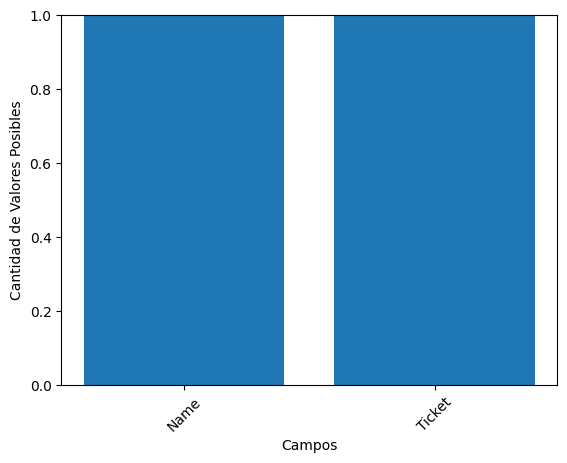

Index(['Name', 'Ticket'], dtype='object')


In [3]:


def contar_variabilidad(df, umbral):
    columnas_alta_variabilidad = []
    for c in df.columns[1:]:
        if len(df[c].unique()) / len(df[c]) > umbral:
            columnas_alta_variabilidad.append(c)

    var_counts = df[columnas_alta_variabilidad].nunique().sort_values(ascending=False)
    filtered_columns = var_counts[var_counts > umbral].index
    fig, ax = plt.subplots()
    ax.bar(x=filtered_columns, height=var_counts[filtered_columns])
    ax.set_xlabel('Campos')
    ax.set_ylabel('Cantidad de Valores Posibles')
    ax.set_ylim(top=1)
    plt.xticks(rotation=45)
    plt.show()
    return filtered_columns

columnas_alta_variabilidad = contar_variabilidad(df_train, 0.65)
print(columnas_alta_variabilidad)


In [4]:
df_train = df_train.drop(columns=columnas_alta_variabilidad)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


In [5]:
def contar_valores_vacios(df):
  null_counts = df.isnull().sum().sort_values(ascending=False)
  filtered_columns = null_counts[null_counts > 0].index
  fig, ax = plt.subplots()
  ax.bar(x=filtered_columns, height=null_counts[filtered_columns]/len(df))
  ax.set_xlabel('Campos')
  ax.set_ylabel('Cantidad de Valores Vacíos')
  ax.set_ylim(top=1)
  return filtered_columns

Index(['Cabin', 'Age', 'Embarked'], dtype='object')


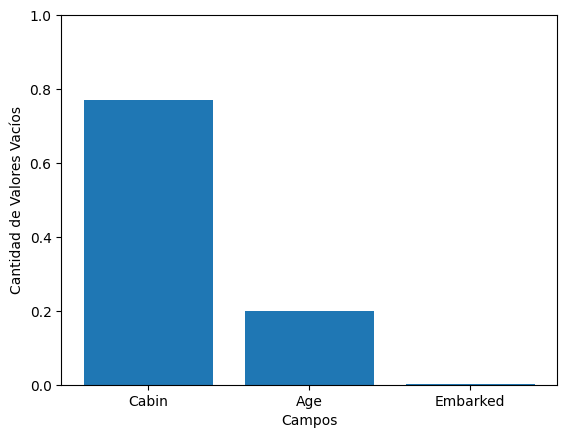

In [6]:
columnas_con_vacios = contar_valores_vacios(df_train)
print(columnas_con_vacios)

In [7]:
df_train = df_train.drop(columns=['Cabin'])

In [8]:
def rellenar_vacios(processedData, columna):
    imputer = SimpleImputer(fill_value=np.nan, strategy='mean')
    imputerst = SimpleImputer(fill_value=np.nan, strategy='most_frequent')
    if type(processedData[columna][1]) != str:
        aux = processedData[[columna]]
        processedData[columna] = imputer.fit_transform(aux)
    else:
      valor_mas_frecuente = processedData[columna].mode()[0]
      processedData[columna].fillna(valor_mas_frecuente, inplace=True)
    return processedData

for c in columnas_con_vacios[1:]:
    df_train = rellenar_vacios(df_train, c)


Index([], dtype='object')

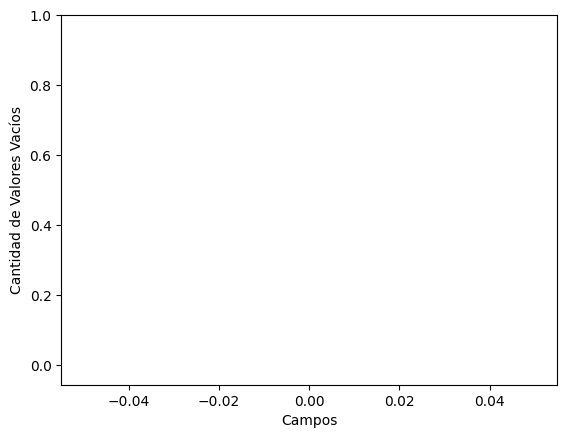

In [9]:
contar_valores_vacios(df_train)

In [10]:
def convertir_numerico(processedData, columna):


  le = LabelEncoder()

  processedData[columna] = le.fit_transform(processedData[columna])
  return processedData


df_train = convertir_numerico(df_train, 'Sex')
df_train = convertir_numerico(df_train, 'Embarked')

In [11]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2


In [12]:
s = df_train['Survived']
df_train = df_train.drop(columns='Survived')
df_train = pd.concat([df_train,s],axis=1)

In [13]:
df_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,3,1,22.0,1,0,7.2500,2,0
1,2,1,0,38.0,1,0,71.2833,0,1
2,3,3,0,26.0,0,0,7.9250,2,1
3,4,1,0,35.0,1,0,53.1000,2,1
4,5,3,1,35.0,0,0,8.0500,2,0


In [14]:
def contar_clases(df_train):
  counts = df_train['Survived'].value_counts()

  # Mostrar el número de elementos de cada clase
  print("Número de elementos de cada clase:")
  print(counts)
  print(counts/sum(counts))
contar_clases(df_train)


Número de elementos de cada clase:
Survived
0    549
1    342
Name: count, dtype: int64
Survived
0    0.616162
1    0.383838
Name: count, dtype: float64


In [15]:
X = df_train.drop(columns=df_train.columns[-1])
y = df_train.drop(columns=df_train.columns[:-1])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [16]:
contar_clases(y_train)

Número de elementos de cada clase:
Survived
0    439
1    273
Name: count, dtype: int64
Survived
0    0.616573
1    0.383427
Name: count, dtype: float64


#Funciones de métricas

In [ ]:
def get_metrics(y_true, y_pred,umbral=None, mostrar_curva=False):
    auc_score = -1
    threshold = None
    if umbral == None:
      if  np.any((y_pred != 0) & (y_pred != 1)):

          y_pred_ = deepcopy(y_pred)
          fpr, tpr, thresholds = roc_curve(y_true, y_pred_)
          auc_score = auc(fpr, tpr)

          specificity = 1 - fpr
          recall = tpr

          optimal_idx = np.argmax(recall - (1 - specificity))
          threshold = thresholds[optimal_idx]

          y_pred_class_optimal = (y_pred_ >= threshold).astype(int)

          cm = confusion_matrix(y_true, y_pred_class_optimal)
      else:
          cm = confusion_matrix(y_true, y_pred)
    else:
      cm = confusion_matrix(y_true, (y_pred >= umbral).astype(int))

    if mostrar_curva:
        plt.figure(figsize=(8, 6))
        plt.plot(specificity, recall, color='blue', lw=2, label='ROC curve')
        plt.plot([0, 1], [1, 0], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Especificidad')
        plt.ylabel('Sensibilidad (Recall)')
        plt.title('Curva ROC')
        plt.legend(loc='lower right')
        plt.show()

    disp = ConfusionMatrixDisplay(confusion_matrix=np.flip(np.flip(cm, axis=0), axis=1), display_labels=[1,0])
    disp.plot(cmap=plt.cm.Reds)
    plt.title("Matriz de Confusión")
    plt.show()

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Sensibilidad:", recall)
    print("Especificidad:", specificity)

    print("F1 Score:", f1_score)

    if auc_score != -1:
        print("AUC:", auc_score)
        print("Umbral óptimo:", threshold)
    return accuracy,precision,recall,specificity,auc_score,f1_score



#Funciones para generación de código LaTex

In [ ]:
labels = ['Perceptrón','Clasificador Logístico','Árbol de Decisión','Clasificador Bayesiano','SVC','Red Neuronal','Autoencoder','KAN','K-MEANS']
train_m = []
test_m = []

def obtener_tabla(labels,metr):
  s = ''
  for i in range(len(labels)):
    s += labels[i]+' '
    for m in metr[i]:

      s += '& '+str(round(m,3))+' '
    s +='\\\\ \hline'+'\n'
  return s



#Métodos Con Aprendizaje Supervisado

##Perceptrón

In [ ]:
clf_percept = linear_model.Perceptron()
clf_percept.fit(x_train, y_train.values.flatten())



Perceptron()

###Resultados de entrenamiento

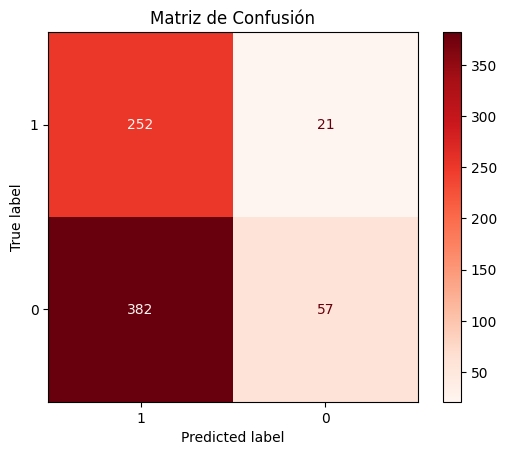

Accuracy: 0.4339887640449438
Precision: 0.39747634069400634
Sensibilidad: 0.9230769230769231
Especificidad: 0.12984054669703873
F1 Score: 0.555678059536935


In [ ]:
y_pred_percept = clf_percept.predict(x_train)
train_m.append(list(get_metrics(y_train, y_pred_percept)))

###Resultados de test

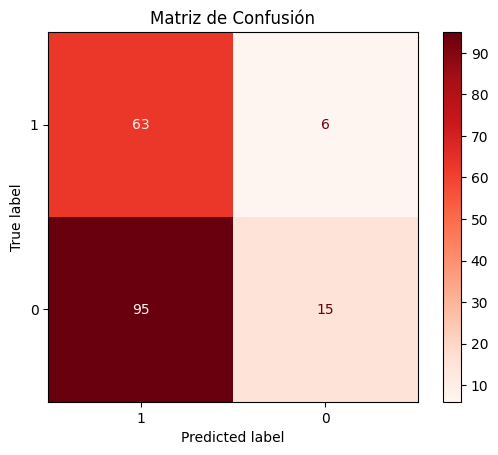

Accuracy: 0.43575418994413406
Precision: 0.3987341772151899
Sensibilidad: 0.9130434782608695
Especificidad: 0.13636363636363635
F1 Score: 0.5550660792951542


In [ ]:
y_pred_percept = clf_percept.predict(x_test)
test_m.append(list(get_metrics(y_test, y_pred_percept)))

##Clasificador Logístico

In [ ]:
clf_logistic = linear_model.LogisticRegression()
clf_logistic.fit(x_train, y_train.values.flatten())



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

###Resultados de entrenamiento

In [ ]:
y_pred_logistic = (clf_logistic.predict_proba(x_train)[:, 1]).astype(float)

train_m.append(list(get_metrics(y_train, y_pred_logistic, None, True)))

###Resultados de test

In [ ]:
y_pred_logistic = (clf_logistic.predict_proba(x_test)[:, 1]).astype(float)

test_m.append(list(get_metrics(y_test, y_pred_logistic, None, True)))

##Árbol de Decisión

In [ ]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(x_train, y_train)



DecisionTreeClassifier()

###Resultados de entrenamiento


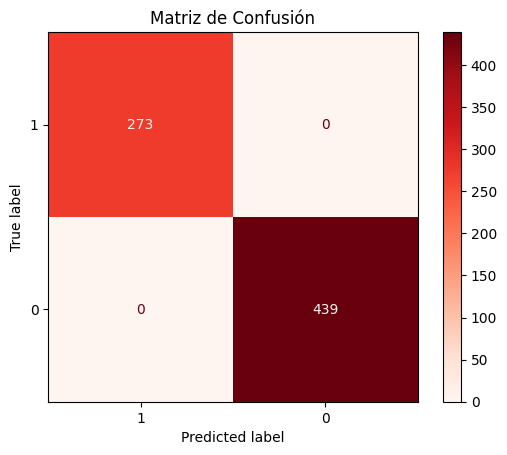

Accuracy: 1.0
Precision: 1.0
Sensibilidad: 1.0
Especificidad: 1.0
F1 Score: 1.0


In [ ]:
y_pred_tree = clf_tree.predict(x_train)

train_m.append(list(get_metrics(y_train, y_pred_tree)))

###Resultados de test

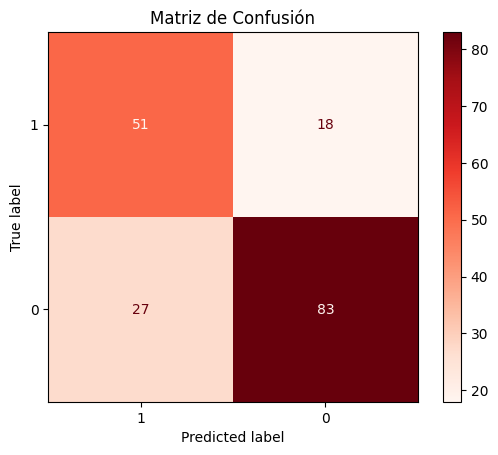

Accuracy: 0.7486033519553073
Precision: 0.6538461538461539
Sensibilidad: 0.7391304347826086
Especificidad: 0.7545454545454545
F1 Score: 0.693877551020408


In [ ]:
y_pred_tree = clf_tree.predict(x_test)
test_m.append(list(get_metrics(y_test, y_pred_tree)))

##Clasificador Bayesiano

In [ ]:
clf_bayes = naive_bayes.CategoricalNB()
clf_bayes.fit(x_train, y_train.values.flatten())



CategoricalNB()

###Resultados de entrenamiento


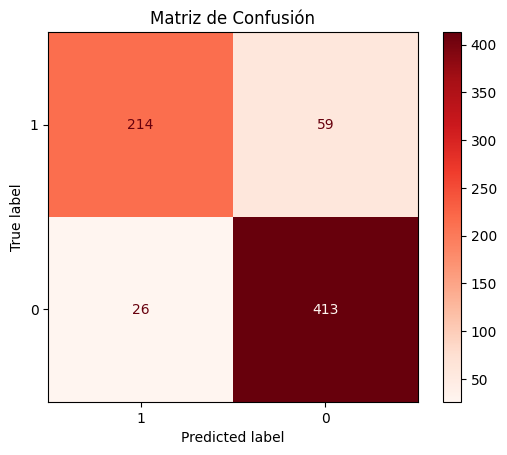

Accuracy: 0.8806179775280899
Precision: 0.8916666666666667
Sensibilidad: 0.7838827838827839
Especificidad: 0.9407744874715261
F1 Score: 0.8343079922027291


In [ ]:
y_pred_bayes = clf_bayes.predict(x_train)

train_m.append(list(get_metrics(y_train, y_pred_bayes)))

###Resultados de test

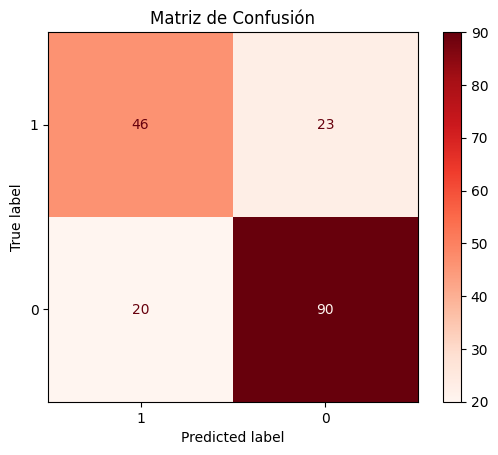

Accuracy: 0.7597765363128491
Precision: 0.696969696969697
Sensibilidad: 0.6666666666666666
Especificidad: 0.8181818181818182
F1 Score: 0.6814814814814815


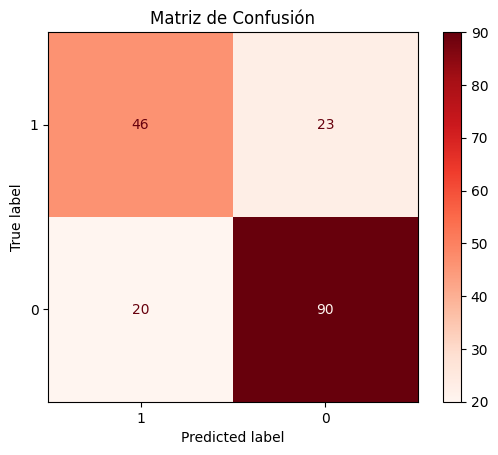

Accuracy: 0.7597765363128491
Precision: 0.696969696969697
Sensibilidad: 0.6666666666666666
Especificidad: 0.8181818181818182
F1 Score: 0.6814814814814815


In [ ]:
y_pred_bayes = clf_bayes.predict(x_test)
get_metrics(y_test, y_pred_bayes)
test_m.append(list(get_metrics(y_test, y_pred_bayes)))


##SVC

In [ ]:
svc = SVC(kernel='rbf', random_state=42,probability=True)
svc.fit(x_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(probability=True, random_state=42)

###Resultados de entrenamiento

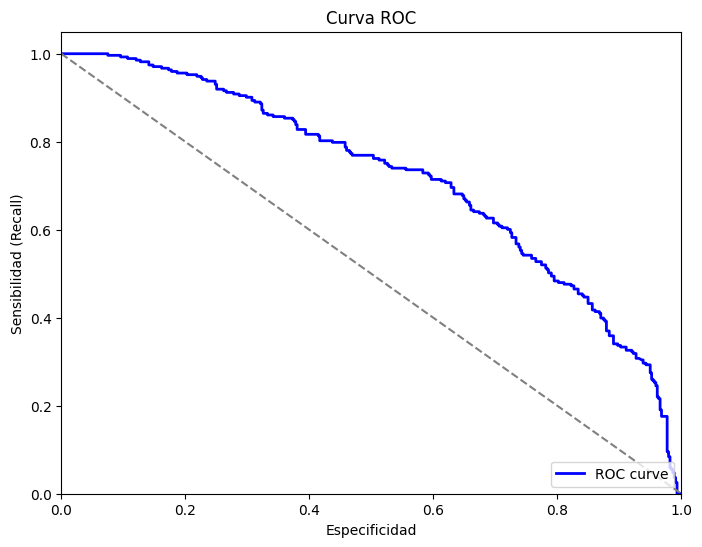

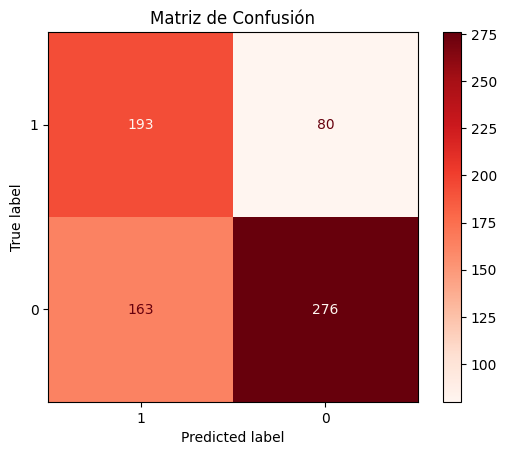

Accuracy: 0.6587078651685393
Precision: 0.5421348314606742
Sensibilidad: 0.706959706959707
Especificidad: 0.6287015945330297
F1 Score: 0.6136724960254374
AUC: 0.7168640016020427
Umbral óptimo: 0.32788676365369496


In [ ]:
y_pred = svc.predict_proba(x_train)

train_m.append(list(get_metrics(y_train,y_pred[:,1],None,True)))

###Resultados de test

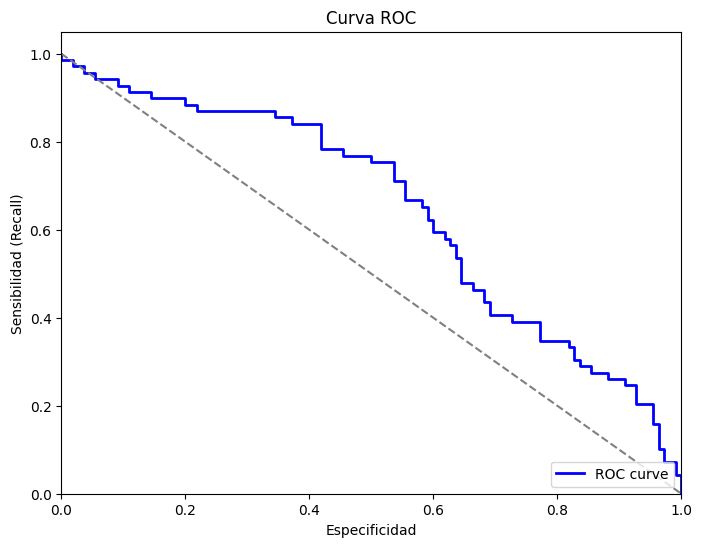

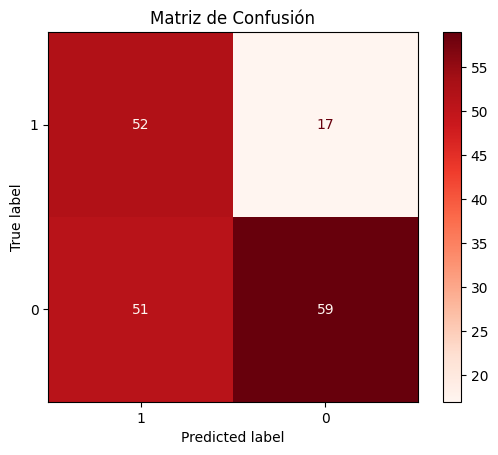

Accuracy: 0.6201117318435754
Precision: 0.5048543689320388
Sensibilidad: 0.7536231884057971
Especificidad: 0.5363636363636364
F1 Score: 0.6046511627906976
AUC: 0.6433465085638999
Umbral óptimo: 0.314982159919368


In [ ]:
y_pred = svc.predict_proba(x_test)
test_m.append(list(get_metrics(y_test,y_pred[:,1],None,True)))

##Red Neuronal Clásica

In [ ]:
scaler = MinMaxScaler()

x_train_normalized = scaler.fit_transform(x_train)

x_test_normalized = scaler.transform(x_test)

In [ ]:
# Define el modelo de la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compila el modelo
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

# Entrena el modelo
history = model.fit(x_train_normalized, y_train, epochs=10, batch_size=32,verbose=False)


###Resultados de entrenamiento

23/23 [==============================] - 0s 2ms/step


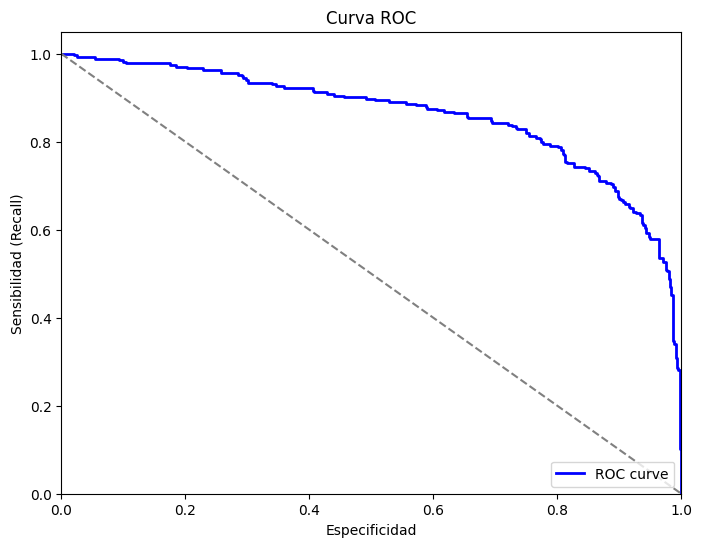

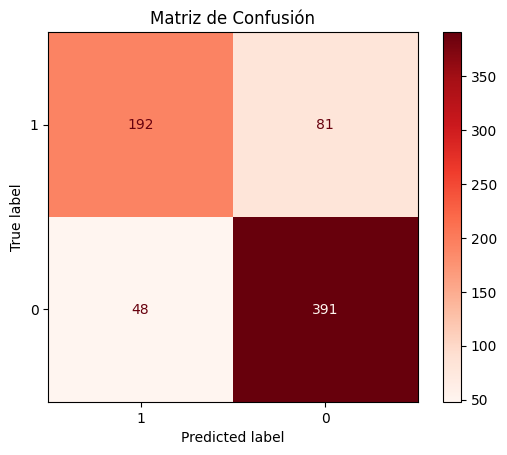

Accuracy: 0.8188202247191011
Precision: 0.8
Sensibilidad: 0.7032967032967034
Especificidad: 0.8906605922551253
F1 Score: 0.7485380116959066
AUC: 0.8616486019675085
Umbral óptimo: 0.5377581


In [ ]:
y_pred = model.predict(x_train_normalized)

train_m.append(list(get_metrics(y_train,y_pred,None,True)))

###Resultados de test

6/6 [==============================] - 0s 2ms/step


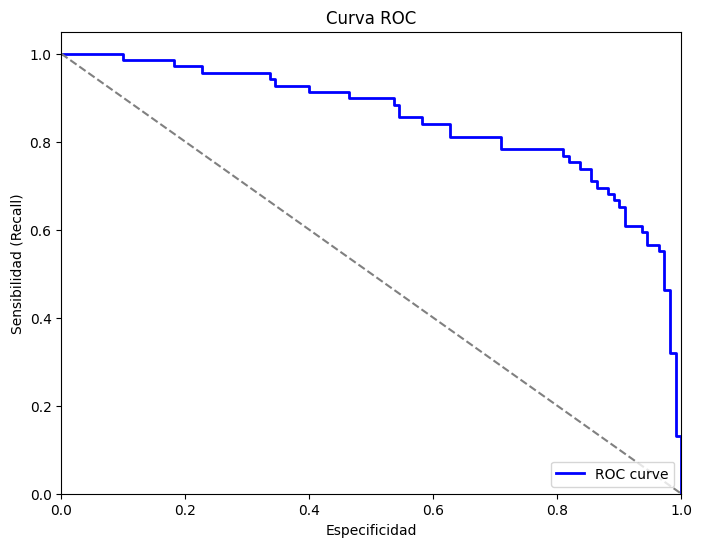

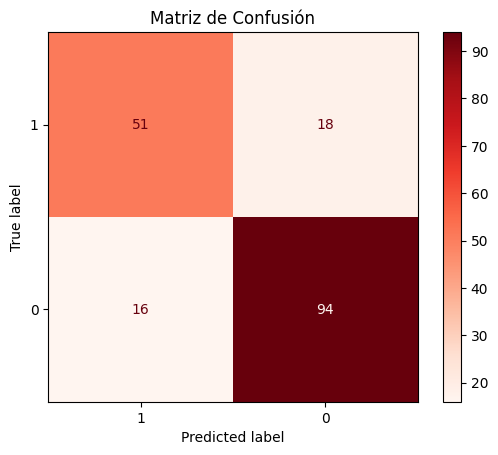

Accuracy: 0.8100558659217877
Precision: 0.7611940298507462
Sensibilidad: 0.7391304347826086
Especificidad: 0.8545454545454545
F1 Score: 0.75
AUC: 0.8507246376811594
Umbral óptimo: 0.46697116


In [ ]:
y_pred = model.predict(x_test_normalized)
test_m.append(list(get_metrics(y_test,y_pred,None,True)))

##Autoencoder

In [ ]:
# Define la dimensión de la entrada
input_dim = x_train_normalized.shape[1]

# Define el codificador
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dense(16, activation='relu')(encoder)
# La capa de salida del codificador es el espacio latente
latent_space = Dense(4, activation='relu')(encoder)

# Define el decodificador
decoder = Dense(16, activation='relu')(latent_space)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(64, activation='relu')(decoder)
# La capa de salida del decodificador es la reconstrucción de la entrada
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

# Construye el autoencoder
autoencoder = Model(input_layer, output_layer)

# Compila el autoencoder
autoencoder.compile(optimizer='adam', loss='mae')

# Entrena el autoencoder
autoencoder.fit(x_train_normalized[(y_train == 0).to_numpy().flatten()], x_train_normalized[(y_train == 0).to_numpy().flatten()], epochs=15, batch_size=32)


Epoch 1/15
14/14 [==============================] - 1s 3ms/step - loss: 0.3867
Epoch 2/15
14/14 [==============================] - 0s 4ms/step - loss: 0.3385
Epoch 3/15
14/14 [==============================] - 0s 3ms/step - loss: 0.2248
Epoch 4/15
14/14 [==============================] - 0s 3ms/step - loss: 0.1501
Epoch 5/15
14/14 [==============================] - 0s 3ms/step - loss: 0.1370
Epoch 6/15
14/14 [==============================] - 0s 3ms/step - loss: 0.1356
Epoch 7/15
14/14 [==============================] - 0s 3ms/step - loss: 0.1354
Epoch 8/15
14/14 [==============================] - 0s 3ms/step - loss: 0.1356
Epoch 9/15
14/14 [==============================] - 0s 2ms/step - loss: 0.1359
Epoch 10/15
14/14 [==============================] - 0s 3ms/step - loss: 0.1349
Epoch 11/15
14/14 [==============================] - 0s 3ms/step - loss: 0.1340
Epoch 12/15
14/14 [==============================] - 0s 3ms/step - loss: 0.1325
Epoch 13/15
14/14 [==============================

###Resultados de entrenamiento

23/23 [==============================] - 0s 2ms/step


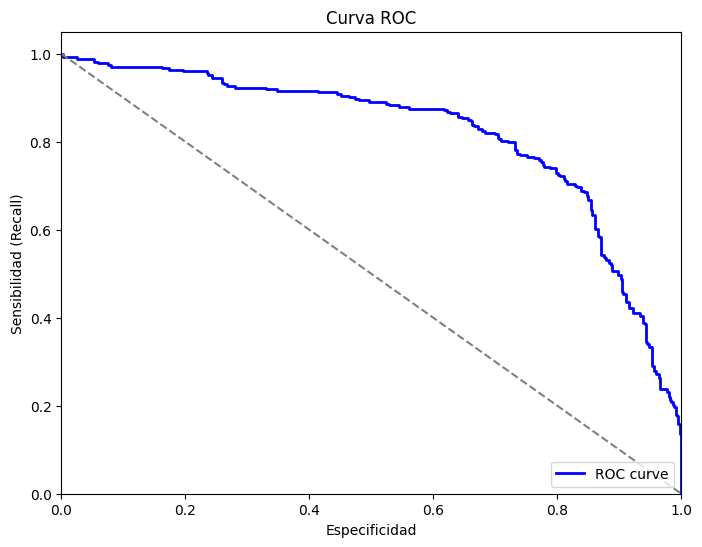

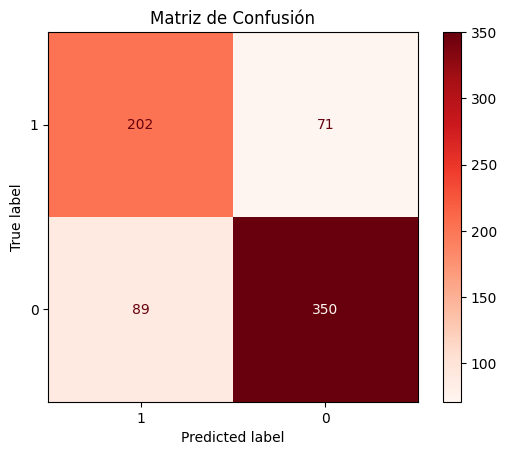

Accuracy: 0.7752808988764045
Precision: 0.6941580756013745
Sensibilidad: 0.73992673992674
Especificidad: 0.7972665148063781
F1 Score: 0.7163120567375887
AUC: 0.8178594374494147
Umbral óptimo: 0.17703993749294597


In [ ]:
reconstructed_x_train = autoencoder.predict(x_train_normalized)

# Calcular el error de reconstrucción (puedes usar cualquier métrica de error adecuada)
reconstruction_errors = np.mean(np.abs(x_train_normalized - reconstructed_x_train), axis=1)


y_pred = reconstruction_errors
train_m.append(list(get_metrics(y_train,y_pred,None,True)))

###Resultados de test

6/6 [==============================] - 0s 2ms/step


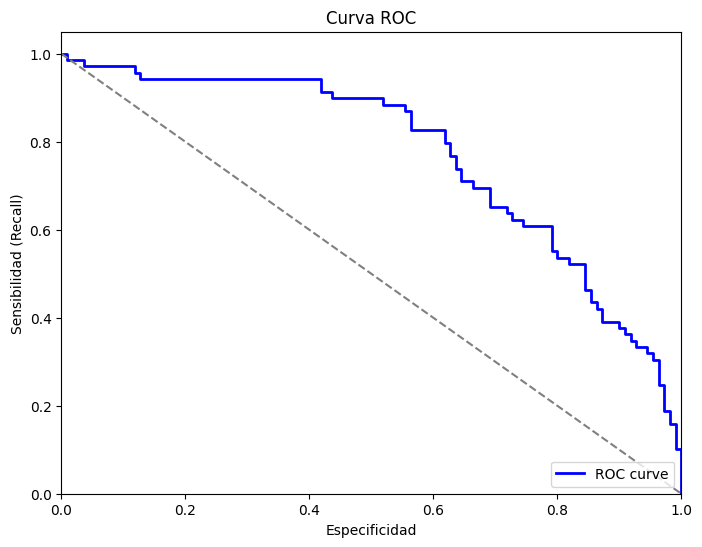

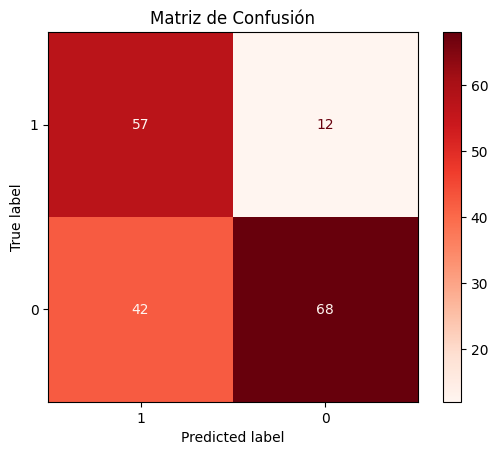

Accuracy: 0.6983240223463687
Precision: 0.5757575757575758
Sensibilidad: 0.8260869565217391
Especificidad: 0.6181818181818182
F1 Score: 0.6785714285714286
AUC: 0.7683794466403162
Umbral óptimo: 0.14542788644651955


In [ ]:
reconstructed_x_test = autoencoder.predict(x_test_normalized)

# Calcular el error de reconstrucción (puedes usar cualquier métrica de error adecuada)
reconstruction_errors = np.mean(np.abs(x_test_normalized - reconstructed_x_test), axis=1)


y_pred = reconstruction_errors
test_m.append(list(get_metrics(y_test,y_pred,None,True)))

##KAN

In [ ]:
!(pip install pykan==0.0.1)
from kan import *


In [ ]:
model = KAN(width=[8,10,1], grid=5, k=3, seed=0)

In [ ]:
dataset = {}
dataset['train_input'] = torch.from_numpy(x_train.to_numpy())
dataset['train_label'] = torch.from_numpy(y_train.to_numpy())
dataset['test_input'] = torch.from_numpy(x_test.to_numpy())
dataset['test_label'] = torch.from_numpy(y_test.to_numpy())

In [ ]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())



In [ ]:
results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));

train loss: 3.79e-01 | test loss: 4.19e-01 | reg: 2.51e+01 : 100%|██| 20/20 [01:06<00:00,  3.31s/it]


In [ ]:
results['train_acc'][-1], results['test_acc'][-1]
train_m.append([results['train_acc'][-1],0,0,0,0,0])
test_m.append([results['test_acc'][-1],0,0,0,0,0])

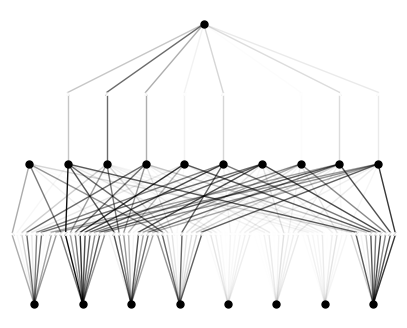

In [ ]:
model.plot()


In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with abs, r2=0.9999999999066816
fixing (0,0,1) with abs, r2=0.9999997065981809
fixing (0,0,2) with abs, r2=0.9999999800847545
fixing (0,0,3) with abs, r2=0.9999999995850903
fixing (0,0,4) with abs, r2=0.9999999863937551
fixing (0,0,5) with abs, r2=0.9999999998875003
fixing (0,0,6) with abs, r2=0.9999999999050858
fixing (0,0,7) with abs, r2=0.9999999957101185
fixing (0,0,8) with abs, r2=0.9999999990709119
fixing (0,0,9) with abs, r2=0.9999999994237689
fixing (0,1,0) with x^4, r2=0.9999999999937396
fixing (0,1,1) with x^3, r2=0.9999999999840322
fixing (0,1,2) with x^3, r2=0.9999999997323105
fixing (0,1,3) with x^4, r2=0.999999999998953
fixing (0,1,4) with x^3, r2=0.9999999999733792
fixing (0,1,5) with x^4, r2=0.9999999999985276
fixing (0,1,6) with x^3, r2=0.9999999999536133
fixing (0,1,7) with x^2, r2=0.9999999698696668
fixing (0,1,8) with x^4, r2=0.999999999998404
fixing (0,1,9) with x^4, r2=0.9999999999998864
fixing (0,2,0) with exp, r2=1.0000000000000016
fixing (0,2,1) 

#Métodos Con Aprendizaje No Supervisado

##K-Means

###Resultados de entrenamiento

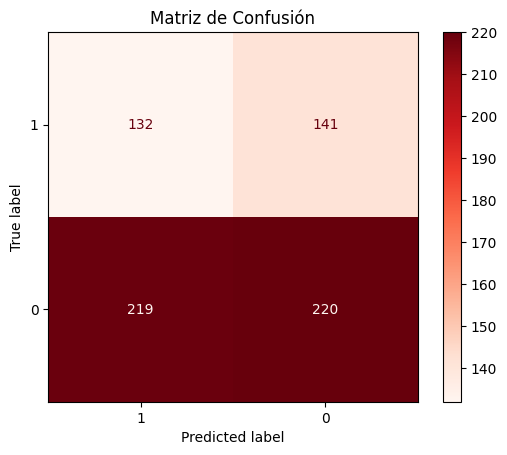

Accuracy: 0.4943820224719101
Precision: 0.37606837606837606
Sensibilidad: 0.4835164835164835
Especificidad: 0.5011389521640092
F1 Score: 0.423076923076923


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(x_train)
train_m.append(list(get_metrics(y_train, kmeans.labels_)))

###Resultados de test

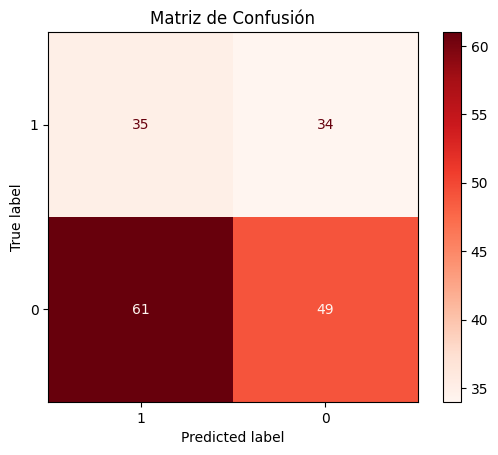

Accuracy: 0.4692737430167598
Precision: 0.3645833333333333
Sensibilidad: 0.5072463768115942
Especificidad: 0.44545454545454544
F1 Score: 0.42424242424242425


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(x_test)
test_m.append(list(get_metrics(y_test, kmeans.labels_)))

#Obtención de tablas LaTex

In [ ]:


print(obtener_tabla(labels,train_m))
print('=============================')
print(obtener_tabla(labels,test_m))

#Optimización de red neuronal

In [ ]:
scaler = MinMaxScaler()

x_train_normalized = scaler.fit_transform(x_train)

x_test_normalized = scaler.transform(x_test)

In [ ]:


class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        # Agrega capas densas
        hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
        for i in range(hp_layers):
            n_units = hp.Choice('n_units' + str(i), values=[16, 32, 64, 128])
            activation = hp.Choice('activation_layer_' + str(i), values=['relu', 'sigmoid'])
            model.add(keras.layers.Dense(units=n_units, activation=activation))

        # Agrega una capa de salida con activación sigmoide para clasificación binaria
        model.add(Dense(1, activation='sigmoid'))

        # Optimizador y tasa de aprendizaje
        hp_optimizer = hp.Choice('optimizer', values=['adam'])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        if hp_optimizer == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
        else:
            optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice('batch_size', values=[16, 32, 64, 128]),
            **kwargs,
        )

# Callbacks
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',  # Monitoriza la precisión de validación
    save_best_only=True,
    mode='max',
)

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",  # Objetivo es maximizar la precisión de validación
    max_trials=500,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
    executions_per_trial=1,
)

# Realiza la búsqueda de hiperparámetros
tuner.search(x_train_normalized, y_train, epochs=20, validation_data=(x_test_normalized, y_test), callbacks=[stop_early, checkpoint_callback])

# Obtiene la mejor combinación de hiperparámetros al finalizar la búsqueda
best_trial = tuner.oracle.get_best_trials(1)[0]
best_hps = best_trial.hyperparameters

print("\nValores de los hiperparámetros:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_normalized, y_train, epochs=20)

y_pred = model.predict(x_test_normalized)
get_metrics(y_test,y_pred)


Epoch 1/20
23/23 [==============================] - 2s 4ms/step - loss: 0.5977 - accuracy: 0.6896
Epoch 2/20
23/23 [==============================] - 0s 3ms/step - loss: 0.4671 - accuracy: 0.7921
Epoch 3/20
23/23 [==============================] - 0s 4ms/step - loss: 0.4528 - accuracy: 0.8020
Epoch 4/20
23/23 [==============================] - 0s 4ms/step - loss: 0.4431 - accuracy: 0.8104
Epoch 5/20
23/23 [==============================] - 0s 3ms/step - loss: 0.4431 - accuracy: 0.8048
Epoch 6/20
23/23 [==============================] - 0s 3ms/step - loss: 0.4402 - accuracy: 0.8020
Epoch 7/20
23/23 [==============================] - 0s 4ms/step - loss: 0.4409 - accuracy: 0.8118
Epoch 8/20
23/23 [==============================] - 0s 3ms/step - loss: 0.4388 - accuracy: 0.8132
Epoch 9/20
23/23 [==============================] - 0s 3ms/step - loss: 0.4373 - accuracy: 0.8146
Epoch 10/20
23/23 [==============================] - 0s 3ms/step - loss: 0.4375 - accuracy: 0.8132
Epoch 11/20
23/23 [

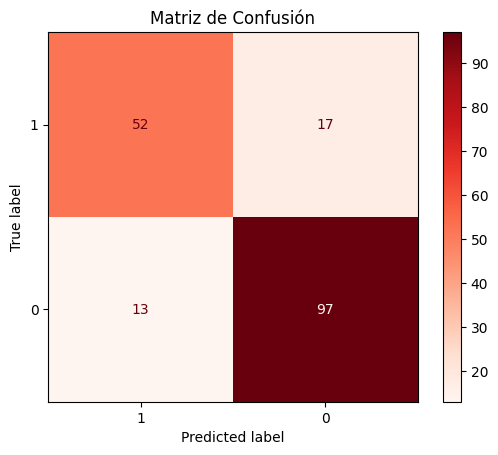

Accuracy: 0.8324022346368715
Precision: 0.8
Sensibilidad: 0.7536231884057971
Especificidad: 0.8818181818181818
F1 Score: 0.7761194029850746
AUC: 0.8677206851119894
Umbral óptimo: 0.51355433


(0.8324022346368715,
 0.8,
 0.7536231884057971,
 0.8818181818181818,
 0.8677206851119894,
 0.7761194029850746)

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_normalized, y_train, epochs=20)

y_pred = model.predict(x_test_normalized)
get_metrics(y_test,y_pred)


In [ ]:
import json

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0].values

# Guardar los mejores hiperparámetros en un archivo JSON
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters, f)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                288       
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4513 (17.63 KB)
Trainable params: 4513 (17.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
for layer in model.layers:
    # Muestra el tipo de capa y la función de activación (si la capa tiene una)
    print(layer.name, "-", layer.__class__.__name__)
    if hasattr(layer, 'activation'):
        print("   Función de activación:", layer.activation.__name__)

dense_6 - Dense
   Función de activación: relu
dense_7 - Dense
   Función de activación: relu
dense_8 - Dense
   Función de activación: sigmoid
dense_9 - Dense
   Función de activación: sigmoid
